<a href="https://colab.research.google.com/github/37stu37/AI/blob/master/OpenQuake_FFE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install Colab / OpenQuake

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
%%capture
!pip install openquake.engine

#Import libraries / paths

In [11]:
import openquake
import configparser
import os
from pathlib import Path
import configparser

In [12]:
folder = Path('/content/drive/My Drive/Colab Notebooks/01_Repository/OpenQuake/oq ffe/oqInput_EventBasedPSHA')

In [13]:
os.chdir(folder)
!pwd

/content/drive/My Drive/Colab Notebooks/01_Repository/OpenQuake/oq ffe/oqInput_EventBasedPSHA


In [22]:
!ls

gmpe_logic_tree-CVH_BNZSEE_0317-simple-LHC.xml
job.ini
rSHM_source-model_bk-NZBCK615_fl-F010519_mMin5pt0.xml
source_model_logic_tree.xml
tmp
vs30Polygoncentroids.xml


#Run OpenQuake

***Shell commands seems to be working using the ! symbol - might be possible to run OpenQuake directly from GoogleColab***


---



In [15]:
# !oq engine --help

In [ ]:
!oq engine --run job.ini --exports csv

# Manage Outputs

In [25]:
folder

PosixPath('/content/drive/My Drive/Colab Notebooks/01_Repository/OpenQuake/oq ffe/oqInput_EventBasedPSHA')

In [27]:
output = folder / 'tmp'
os.listdir(output)

['events_2.csv',
 'sitemesh_2.csv',
 'gmf-data_2.csv',
 'sigma_epsilon_2.csv',
 'hazard_curve-mean-PGA_2.csv',
 'quantile_curve-0.5-PGA_2.csv',
 'quantile_curve-0.84-PGA_2.csv',
 'ruptures_2.csv']

## import libraries

In [29]:
%%time
%%capture
!apt update
!apt upgrade
!apt install gdal-bin python-gdal python3-gdal
# Install rtree - Geopandas requirment
!apt install python3-rtree
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes
!pip install memory_profiler

#contextily
!pip3 install contextily

CPU times: user 1.22 s, sys: 272 ms, total: 1.49 s
Wall time: 6min 5s


In [49]:
import pandas as pd
import numpy as np
from shapely.geometry import box
import geopandas as gpd
import matplotlib.pyplot as plt
from textwrap import wrap
from sklearn import preprocessing
import contextily as ctx
import seaborn as sns

plt.style.use('seaborn-colorblind')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## check outputs

In [46]:
hzdCurves = pd.read_csv(output / 'hazard_curve-mean-PGA_2.csv', header = 1)
events = pd.read_csv(output / 'events_2.csv')
gmf = pd.read_csv(output / 'gmf-data_2.csv')

In [56]:
len(hzdCurves)

76

In [45]:
hzdCurves.iloc[:5,:6]

,lon,lat,depth,poe-0.1000000,poe-0.4000000,poe-0.6000000
0,174.82111,-41.1643,0.0,0.068003,0.003804,0.001249
1,174.72530,-41.2838,0.0,0.069522,0.003944,0.001561
2,174.78860,-41.2526,0.0,0.069570,0.003742,0.001467
3,174.80280,-41.2495,0.0,0.066316,0.003990,0.001311
4,174.76871,-41.2825,0.0,0.069000,0.003820,0.001374


In [55]:
curveFile = output / 'hazard_curve-mean-PGA_2.csv'

In [53]:
def getHazCurves(hazCurveFile, IMs=None, row=0):
    """
    Input: OQ hazard curve file, IMs targets (array), row number (linked to site)
    Output: IMs array, hazPoes (corresponding probability of exceedences),
    hazRates (corresponding rate of hazard - PDF )
    """
    if IMs is None:
        IMs=np.arange(0,10,0.01)
    # HAZARD CURVE
    fName = hazCurveFile
    df = pd.read_csv(fName, header=1)
    # Reformat columns names
    oqIMs = [x.split('-')[-1] for x in df.columns[3:]]
    oqIMs = [float(x) for x in oqIMs]
    # Interp haz poes at IMs
    hazPoes=np.interp(IMs, oqIMs, df.loc[row][3:])
    # Calculate the rate of each IM
    hazRates=[hazPoes[i]-hazPoes[i+1] for i in range(0,len(hazPoes)-1)]

    return IMs, hazPoes, hazRates

In [58]:
IM, Poes, Rates = getHazCurves(curveFile)

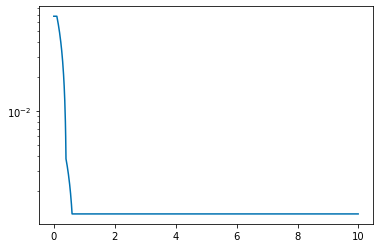

In [65]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1)
ax1.plot(IM, Poes)
ax1.set_yscale("log")